In [128]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import cv2
import tensorflow as tf
import os
import os
import random
import shutil
import sys
import shutil
import csv
from PIL import Image
import matplotlib.patches as mpatches

In [2]:
N1 = 69225 % 2

### Calculando a área da Celula

In [7]:
def calculaAreaPerimetroImagem(img_cv2):
  
  imagem_cinza = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2GRAY)
  _, mascara_binaria = cv2.threshold(imagem_cinza, 1, 255, cv2.THRESH_BINARY)
  contornos, _ = cv2.findContours(mascara_binaria, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  mascara_colorida = np.zeros_like(img_cv2)
  cv2.drawContours(mascara_colorida, contornos, -1, (255, 255, 255), thickness=cv2.FILLED)

  # Exibir a imagem original, a máscara e a parte colorida
  area_branca = np.sum(mascara_binaria == 255)
  
  
  total_perimetro = 0
  
  for contorno in contornos:
    perimeter = cv2.arcLength(contorno, closed=True)
    total_perimetro += perimeter
  
  return area_branca, total_perimetro


### Calculando Compacidade

In [112]:
def calcularCompacidade(img_cv2):
  area, perimetro = calculaAreaPerimetroImagem(img_cv2)
  
  compacidade = area / (perimetro**2)
  
  return round(compacidade, 4)

### Calculando Excentricidade

In [9]:
def calcularExcentricidades(img_cv2):
  
  imagem_cinza = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2GRAY)
  _, mascara_binaria = cv2.threshold(imagem_cinza, 1, 255, cv2.THRESH_BINARY)
  contornos, _ = cv2.findContours(mascara_binaria, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  maior_contorno = max(contornos, key=cv2.contourArea)

    
  if len(maior_contorno) >= 5:
    (elipse_x, elipse_y), (eixo_maior, eixo_menor), _ = cv2.fitEllipse(maior_contorno)
    # Restante do seu código
  else:
    return "-"


  # Calcular excentricidade
  
  if(eixo_maior != 0 and eixo_menor != 0):
    value_mid = round((eixo_menor / eixo_maior)**2, 2)
  else:
    return "-"
  
  excentricidade = round(np.sqrt(value_mid-1),2)
  
  return excentricidade

In [113]:
csv = {'id_cel': [],
       'label': [],
       'area': [],
       'compacidade': [],
       'excentricidade': [],
       }

path_dataset_segmentation = "./data/segmentation_dataset/"


for pasta_atual, subpastas, arquivos in os.walk(path_dataset_segmentation):
    for arquivo in arquivos:
        caminho_completo = os.path.join(pasta_atual, arquivo)
        
        imagem = cv2.imread(caminho_completo)
        
        
        area, _ = calculaAreaPerimetroImagem(imagem)
        
        nomeSplit = caminho_completo.split("\\")
        classeSpli = nomeSplit[0].split("/")
        nomeCel = nomeSplit[1].replace(".png", "")
        nomeClasse = classeSpli[len(classeSpli)-1]
        csv['id_cel'].append(nomeCel)

        if(area > 10):
          csv['area'].append(round(area,2))
          csv['label'].append(nomeClasse)
          csv['compacidade'].append(calcularCompacidade(imagem))
          csv['excentricidade'].append(calcularExcentricidades(imagem))
        else:
          csv['area'].append("Erro na Segmentação")
          csv['label'].append(nomeClasse)
          csv['compacidade'].append("Erro na Segmentação")
          csv['excentricidade'].append("Erro na Segmentação")
          
  
       
df = pd.DataFrame(csv)
df.to_csv('csv_pt2.csv', index=False)       


In [70]:
df = pd.read_csv("csv_pt2.csv")

### Filtrando dataset

In [35]:
df_filtrado = df[df.applymap(lambda x: x != "Erro na Segmentação").all(axis=1)]
df_filtrado.to_csv('csv_pt2_sem_nulos.csv', index=False)

C:\Users\Viny\AppData\Local\Temp\ipykernel_11704\3115453440.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_filtrado = df[df.applymap(lambda x: x != "Erro na Segmentação").all(axis=1)]


### Gerando scatterplot com as caracteristicas calculadas

#### Area X Compacidade

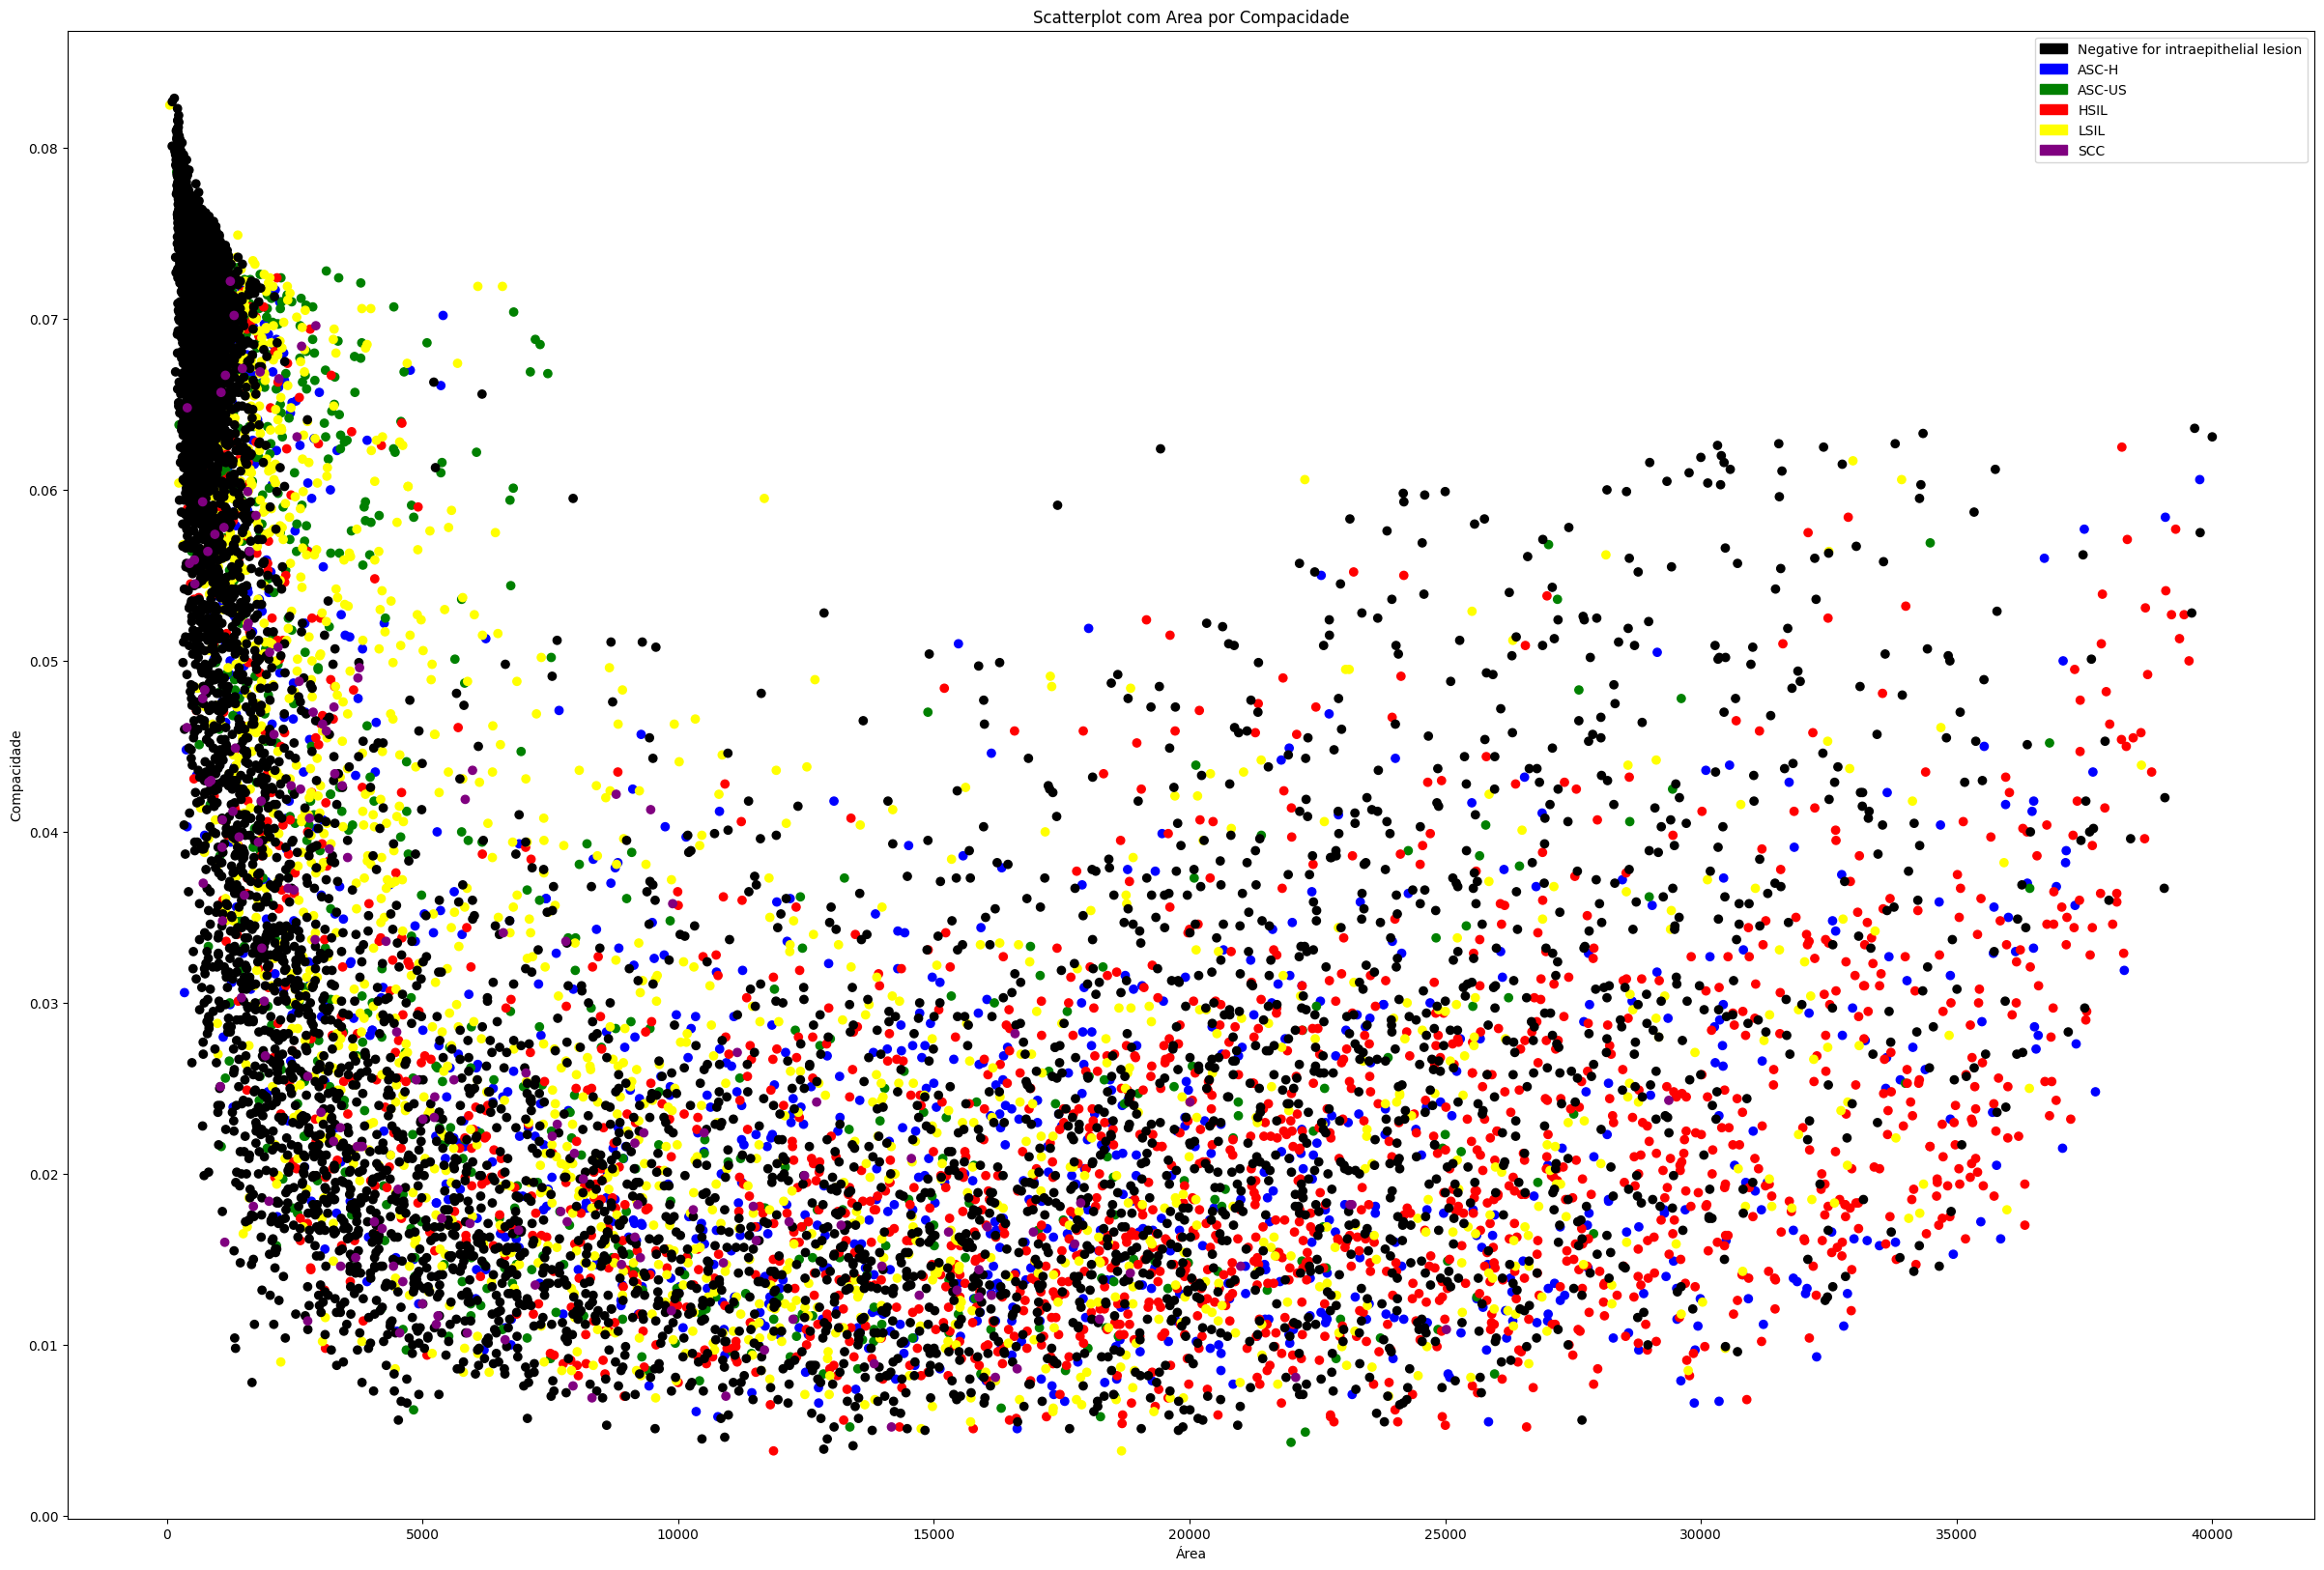

In [127]:
df = pd.read_csv('csv_pt2.csv')

cores = {'Negative for intraepithelial lesion': 'black', 'ASC-H': 'blue', "ASC-US":"green", 'HSIL': 'red', 'LSIL': 'yellow','SCC': 'purple',}

# Adicionar uma coluna 'Cor' com as cores correspondentes às classes
df['Cor'] = df['label'].map(cores)
plt.figure(figsize=(30, 20))

# Plotar o scatterplot
plt.scatter(df['area'], df['compacidade'], c=df['Cor'], label=df['label'])

# Tamanho da Figura

# Adicionar rótulos e título
plt.xlabel('Área')
plt.ylabel('Compacidade')
plt.title('Scatterplot com Area por Compacidade')

# Criando patches das legendas
patches = [mpatches.Patch(color=color, label=label) for label, color in cores.items()]

# Adicionar uma legenda
plt.legend(handles=patches)

# Exibir o gráfico
plt.show()

#### Area x Excentricidade

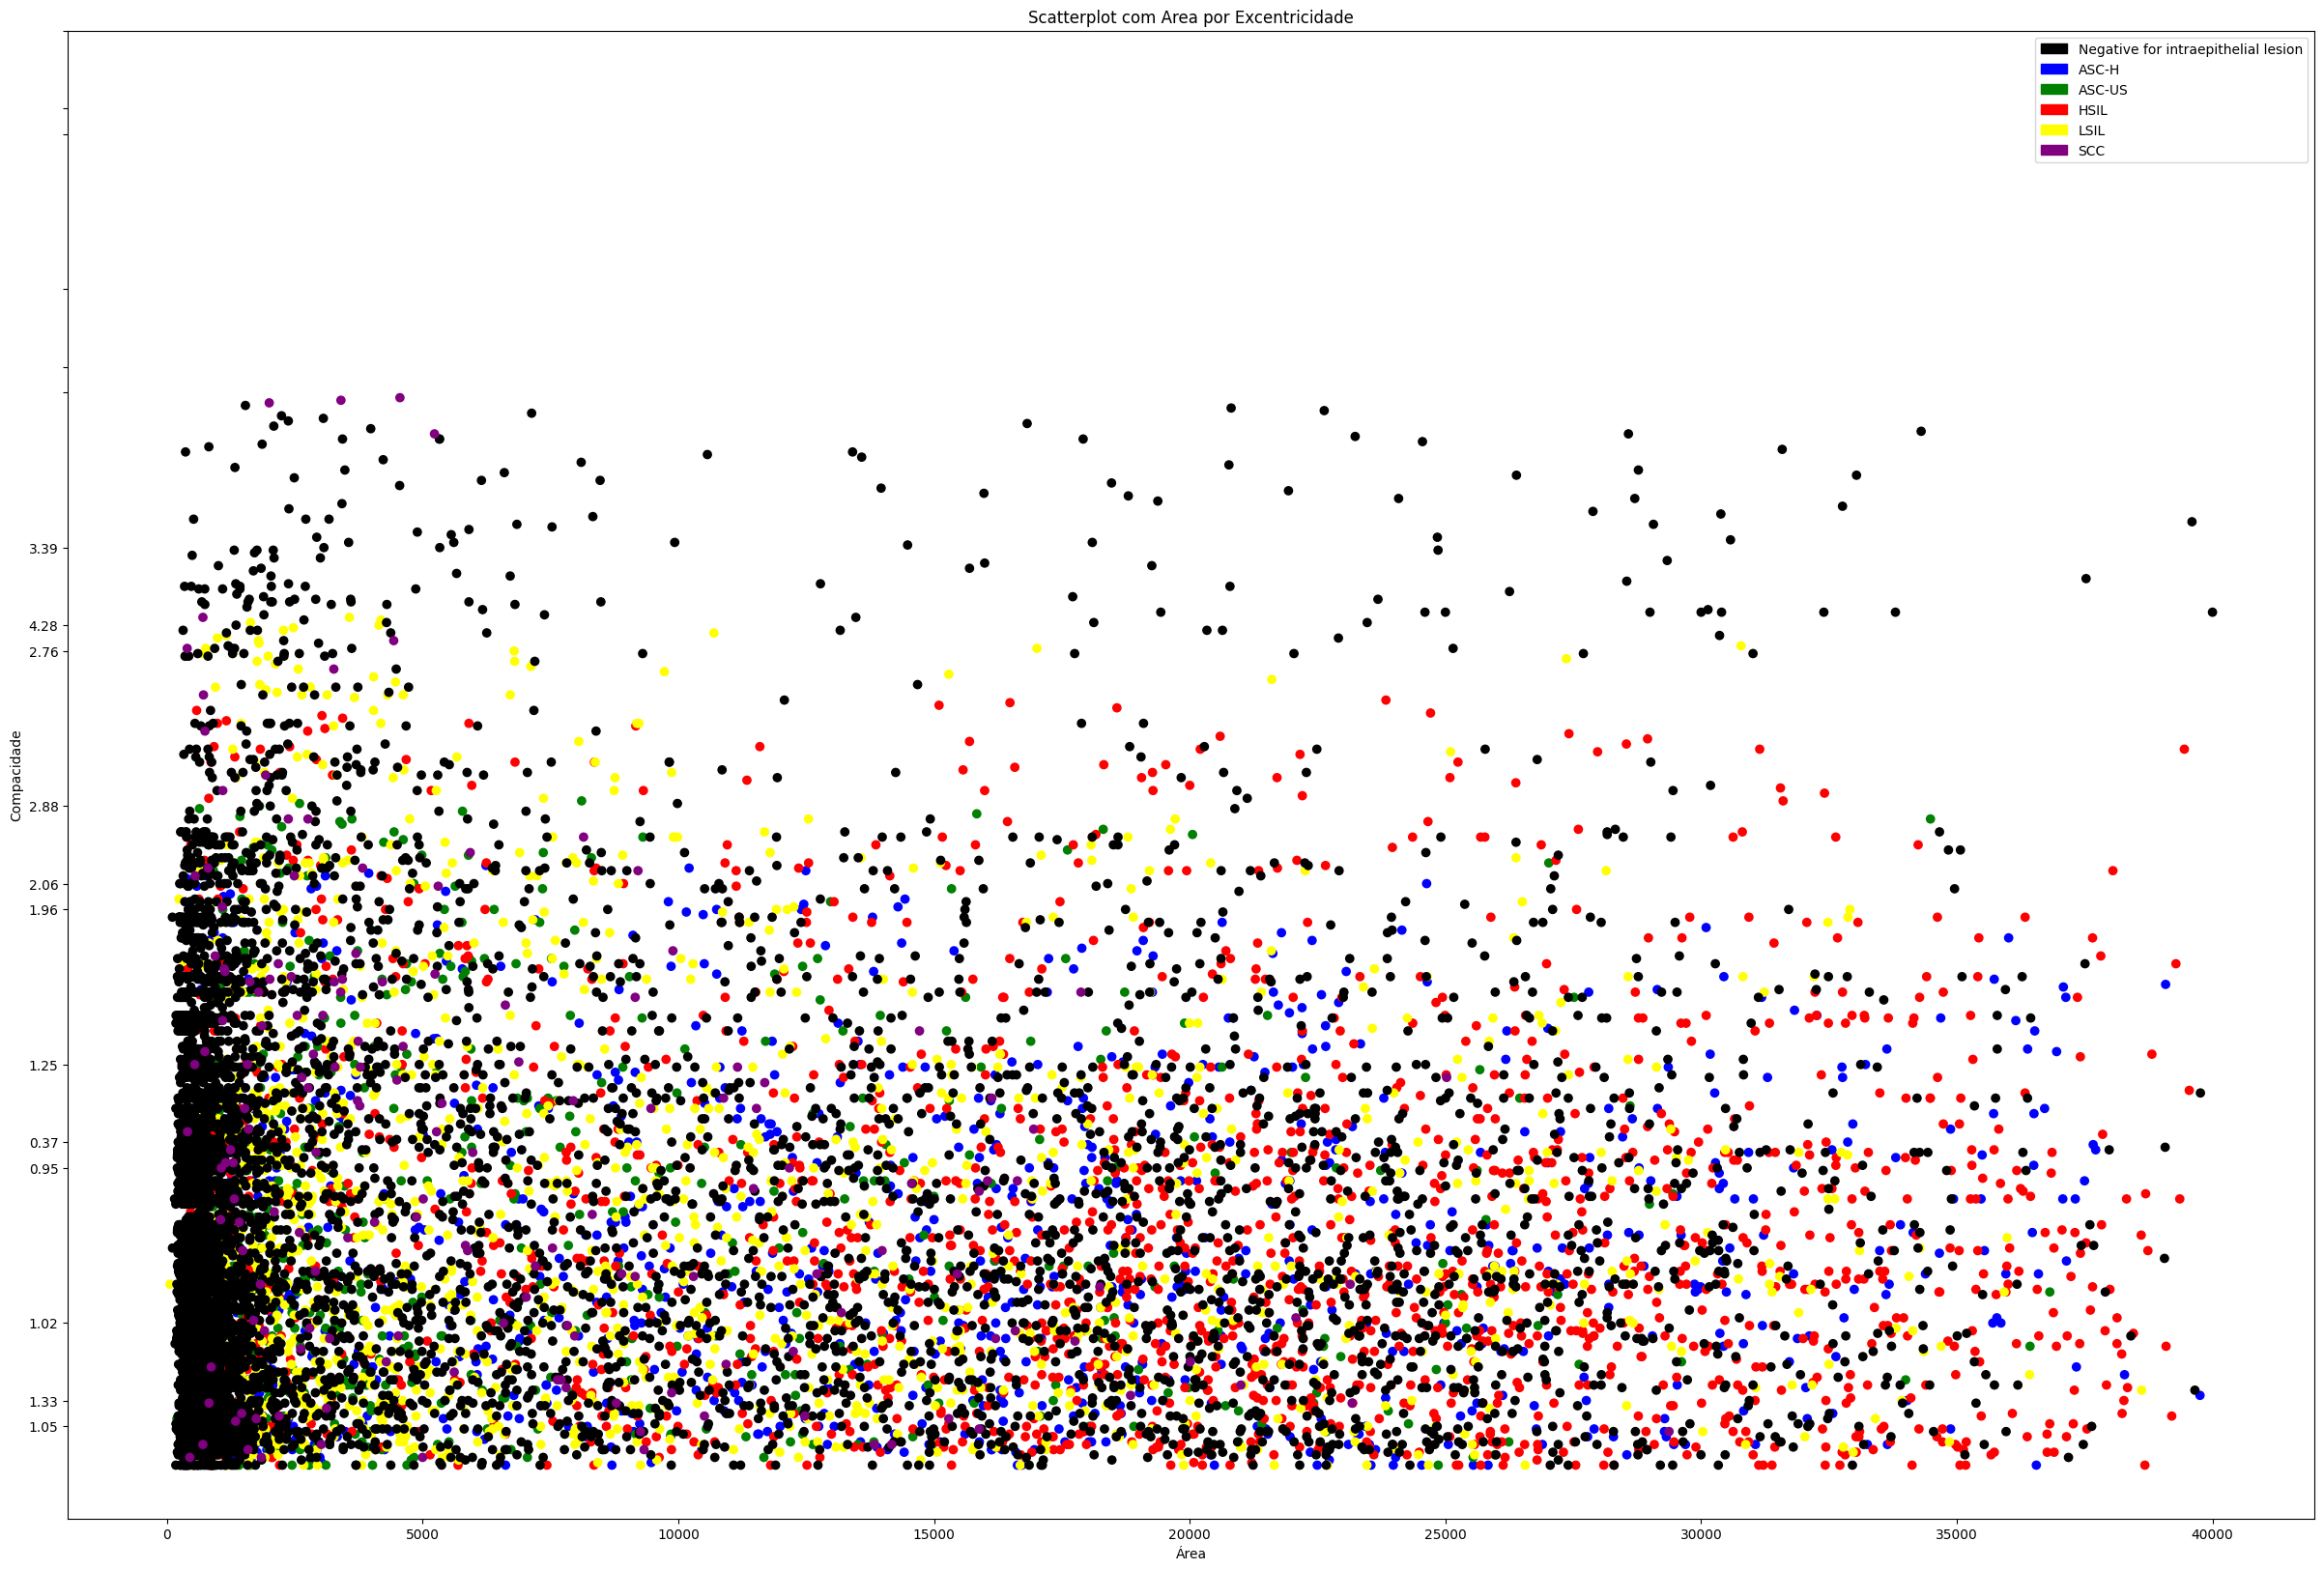

In [125]:
df = pd.read_csv('csv_pt2.csv')

cores = {'Negative for intraepithelial lesion': 'black', 'ASC-H': 'blue', "ASC-US":"green", 'HSIL': 'red', 'LSIL': 'yellow','SCC': 'purple',}

# Adicionar uma coluna 'Cor' com as cores correspondentes às classes
df['Cor'] = df['label'].map(cores)
plt.figure(figsize=(30, 20))

# Plotar o scatterplot
plt.scatter(df['area'], df['excentricidade'], c=df['Cor'], label=df['label'])

# Tamanho da Figura

# Adicionar rótulos e título
plt.xlabel('Área')
plt.ylabel('Compacidade')
plt.title('Scatterplot com Area por Excentricidade')

# Criando patches das legendas
patches = [mpatches.Patch(color=color, label=label) for label, color in cores.items()]

intervalos_y = [15, 25, 55, 115, 125, 155, 215, 225, 255, 315, 325, 355, 415, 425, 455, 515, 525, 555]
plt.yticks(intervalos_y)
# Adicionar uma legenda
plt.legend(handles=patches)

# Exibir o gráfico
plt.show()

### Dividindo o dataset em treino e teste

In [136]:
def obter_nomes_pastas(diretorio):
    nomes_pastas = []
    for nome in os.listdir(diretorio):
        if os.path.isdir(os.path.join(diretorio, nome)):
            nomes_pastas.append(nome)
    return nomes_pastas
  
  
# Exemplo de uso
cwd = os.getcwd()


diretorio = cwd + "/data/segmentation_dataset/"
pastas = obter_nomes_pastas(diretorio)

diretorio_origem = diretorio
diretorio_destino = cwd + '/data/segentation_dataset_treino/'

percent = 0.8

for each in pastas:

    # Diretório contendo todas as imagens
    diretorio_imagens = diretorio_origem + f'/{each}/'

    # Diretório para salvar as imagens de treinamento
    diretorio_treinamento = diretorio_destino + f'/train/{each}/'

    # Diretório para salvar as imagens de teste
    diretorio_teste = diretorio_destino + f'/test/{each}/'

    # Lista todas as imagens no diretório
    imagens = os.listdir(diretorio_imagens)

    # Embaralha a lista de imagens
    random.shuffle(imagens)

    # Calcula o índice para dividir as imagens
    indice_divisao = int(percent * len(imagens))

    # Separa as imagens em treinamento e teste
    imagens_treinamento = imagens[:indice_divisao]
    imagens_teste = imagens[indice_divisao:]

    if not (os.path.exists(diretorio_teste)):
        os.makedirs(diretorio_teste)

    if not (os.path.exists(diretorio_treinamento)):
        os.makedirs(diretorio_treinamento)

    # Move as imagens para os diretórios correspondentes
    for imagem in imagens_treinamento:
        shutil.copy(os.path.join(diretorio_imagens, imagem),
                    diretorio_treinamento)

    for imagem in imagens_teste:
        shutil.copy(os.path.join(diretorio_imagens, imagem), diretorio_teste)



d:\AREA_DE_TRABALHO\Faculdade_6_Periodo\pai\pai-papanicolau\src\AI/data/segmentation_dataset/
['ASC-H', 'ASC-US', 'HSIL', 'LSIL', 'Negative for intraepithelial lesion', 'SCC']
